In [4]:
pip install pdf2image

In [5]:
pip install poppler-utils

In [6]:
pip install PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 17.2 MB/s eta 0:00:00


In [7]:
# Установка необходимых пакетов
!apt-get update > /dev/null
!apt-get install -y poppler-utils
!pip install pdf2image

# Проверка установки poppler
!which pdftoppm  # Должен показать путь к бинарнику, например /usr/bin/pdftoppm

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libpoppler-dev libpoppler-private-dev libpoppler118
Recommended packages:
  poppler-data
The following NEW packages will be installed:
  poppler-utils
The following packages will be upgraded:
  libpoppler-dev libpoppler-private-dev libpoppler118
3 upgraded, 1 newly installed, 0 to remove and 96 not upgraded.
Need to get 1,469 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libpoppler-private-dev amd64 22.02.0-2ubuntu0.7 [199 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libpoppler-dev amd64 22.02.0-2ubuntu0.7 [5,180 B]
Get:3 http:/

In [8]:
import pathlib
import os
from pdf2image import convert_from_path

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, Sequential

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Загружаем датасет

In [3]:
dataset_email = pathlib.Path("/content/drive/MyDrive/Neuro2Sem/email/")
dataset_resume = pathlib.Path("/content/drive/MyDrive/Neuro2Sem/resume/")
dataset_scientific = pathlib.Path("/content/drive/MyDrive/Neuro2Sem/scientific_publication/")

image_count_email = len(list(dataset_email.glob("*.png")))
image_count_resume = len(list(dataset_resume.glob("*.png")))
image_count_scientific = len(list(dataset_scientific.glob("*.png")))

print(f"Всего изображений email: {image_count_email} , Всего изображений resume: {image_count_resume}, Всего изображений scientific: {image_count_scientific}")

Всего изображений email: 105 , Всего изображений resume: 78, Всего изображений scientific: 102


Нейросеть

In [9]:
batch_size = 20
img_width = 256
img_height = 256

train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/Neuro2Sem/",
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/Neuro2Sem/",
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size)

class_names = train_ds.class_names
print(f"Class names: { class_names }")

#cache

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)


Found 285 files belonging to 3 classes.
Using 228 files for training.
Found 285 files belonging to 3 classes.
Using 57 files for validation.
Class names: ['email', 'resume', 'scientific_publication']


Создаем модель, компилируем и выводим summary

In [28]:
num_classes = len(class_names)
model = Sequential([
    # Нормализация
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # Аугментация (новый синтаксис)
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),

    # Основная архитектура
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),

    # Регуляризация
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

# Компиляция модели
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

# Вывод информации о модели
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip_1 (RandomFlip)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_1 (RandomRotation)   │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom_1 (RandomZoom)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast_1 (RandomContrast)   │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 256, 256, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 128, 128, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       8,388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,412,707 (32.09 MB)

 Trainable params: 8,412,707 (32.09 MB)

 Non-trainable params: 0 (0.00 B)

Обучение модели

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.3559 - loss: 3.7358 - val_accuracy: 0.5789 - val_loss: 1.0391
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.3800 - loss: 1.0711 - val_accuracy: 0.5088 - val_loss: 1.0591
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.4550 - loss: 1.0759 - val_accuracy: 0.2807 - val_loss: 1.2338
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.5171 - loss: 0.9751 - val_accuracy: 0.6140 - val_loss: 0.8877
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.6215 - loss: 0.8055 - val_accuracy: 0.5614 - val_loss: 1.6105
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.5907 - loss: 0.7426 - val_accuracy: 0.6667 - val_loss: 0.7329
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.7172 - loss: 0.6052 - val_accuracy: 0.6842 - val_loss: 0.7211
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7191 - loss: 0.5366 - val_accuracy: 0.6316 - val_loss:

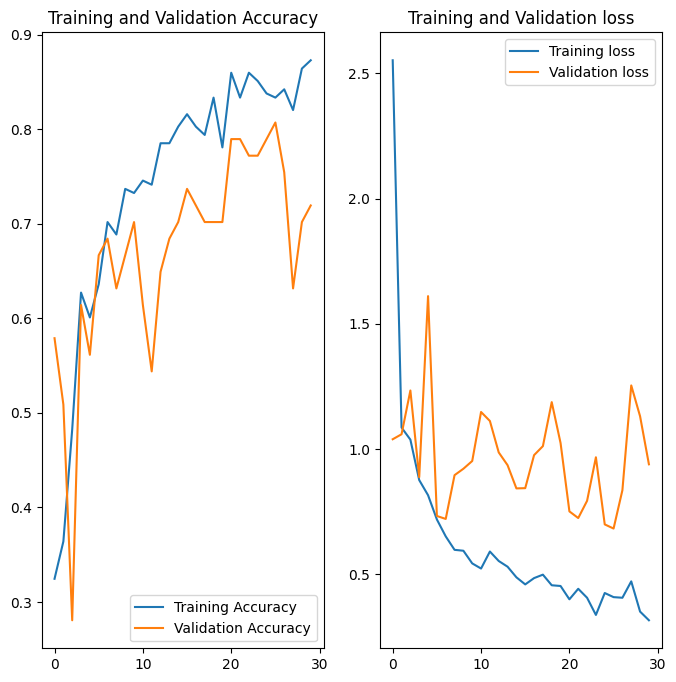

In [29]:
#кол-во эпох обучения

epochs = 30
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

#Визуализируем Training и Validation результаты
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize = (8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training loss')
plt.plot(epochs_range, val_loss, label = 'Validation loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation loss')
plt.show()

Сохранение модели


In [30]:
import os

gdrive_path = "/content/drive/My Drive/TestNeuro/"

filename = gdrive_path
#model.save_weights('my_model_weights_V5.h5')
model.save(filename + 'my_model_V5.h5')

загрузка модели

In [10]:
from keras.models import load_model

gdrive_path = "/content/drive/My Drive/TestNeuro/"

filename = gdrive_path
model = load_model(filename + 'my_model_V5.h5')

print(f"Загрузка завершена модели: { model }")

Загрузка завершена модели: <Sequential name=sequential_1, built=True>


Загрузка изображения

In [11]:
import os
import shutil
from os import path

dest_folders = {
        'email': "/content/drive/My Drive/TestNeuro/ReadyEmail/",
        'resume': "/content/drive/My Drive/TestNeuro/ReadyResume/",
        'scientific_publication': "/content/drive/My Drive/TestNeuro/ReadyScience/"
    }

em = 0
res = 0
sc = 0

def process_single_page(pdf_path, output_folder, page_number):
    """
    Конвертирует одну страницу PDF в PNG и обрабатывает ее
    :param pdf_path: путь к PDF файлу
    :param output_folder: папка для сохранения
    :param page_number: номер страницы (начиная с 1)
    :return: путь к сохраненному файлу
    """
    # Конвертируем только одну страницу
    images = convert_from_path(pdf_path, first_page=page_number, last_page=page_number)

    if not images:
        return None

    output_path = os.path.join(output_folder, f"page_{page_number}.png")
    images[0].save(output_path, "PNG")
    print(f"Сохранено: {output_path}")

    # Обрабатываем изображение
    classify_and_move_image(output_path)

    return output_path

def classify_and_move_image(image_path):
    """
    Классифицирует изображение и перемещает его в нужную папку
    :param image_path: путь к изображению
    """
    global em, res, sc, dest_folders
    img = tf.keras.utils.load_img(image_path, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    img_name = os.path.basename(image_path)
    predicted_class = class_names[np.argmax(score)]
    confidence = 100 * np.max(score)

    print(f"Страница {img_name}: {predicted_class} ({confidence:.2f}% вероятность)")


    if(predicted_class == 'email') :
      em += 1
      #shutil.copy(img_directory_name, emfile)
      print(em)

    if(predicted_class == 'resume') :
      res += 1
      #shutil.copy(img_directory_name, resfile)
      print(res)

    if(predicted_class == 'scientific_publication') :
      sc += 1
      #shutil.copy(img_directory_name, scfile)
      print(sc)
    # Создаем папки если нужно
    for folder in dest_folders.values():
        os.makedirs(folder, exist_ok=True)

def process_pdf_by_pages(pdf_path, output_folder, max_pages=None):
    """
    Обрабатывает PDF постранично
    :param pdf_path: путь к PDF
    :param output_folder: папка для временного сохранения
    :param max_pages: максимальное количество страниц для обработки
    """
    global em, res, sc, dest_folders
    os.makedirs(output_folder, exist_ok=True)

    # Получаем общее количество страниц
    from PyPDF2 import PdfReader
    total_pages = len(PdfReader(pdf_path).pages)

    if max_pages:
        total_pages = min(total_pages, max_pages)

    for page_num in range(1, total_pages + 1):
        print(f"\nОбработка страницы {page_num} из {total_pages}")
        process_single_page(pdf_path, output_folder, page_num)

    max_count = max(em, res, sc)
    if em >= res and em >= sc:
      max_doc_type = "email"
      dest_path = os.path.join(dest_folders[max_doc_type], pdf_file)
      shutil.copy(pdf_path, dest_path)

    elif res >= em and res >= sc:
      max_doc_type = "resume"
      dest_path = os.path.join(dest_folders[max_doc_type], pdf_file)
      shutil.copy(pdf_path, dest_path)

    else:
      max_doc_type = "scientific_publication"
      dest_path = os.path.join(dest_folders[max_doc_type], pdf_file)
      shutil.copy(pdf_path, dest_path)

    print(f"Наибольшее количество: {max_count} ({max_doc_type})")
    print(f"\nОбработка завершена. Всего обработано {total_pages} страниц.")

# Пример использования
pdf_file = "vestnik.pdf"
pdf_path = "/content/drive/MyDrive/TestNeuro/" + pdf_file
output_dir = "/content/drive/MyDrive/TestNeuro/temp_output"

# Обрабатываем по одной странице (можно указать max_pages для ограничения)
process_pdf_by_pages(pdf_path, output_dir, max_pages=10)  # Обработает первые 10 страниц


Обработка страницы 1 из 10
Сохранено: /content/drive/MyDrive/TestNeuro/temp_output/page_1.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
Страница page_1.png: resume (98.01% вероятность)
1

Обработка страницы 2 из 10
Сохранено: /content/drive/MyDrive/TestNeuro/temp_output/page_2.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Страница page_2.png: scientific_publication (99.50% вероятность)
1

Обработка страницы 3 из 10
Сохранено: /content/drive/MyDrive/TestNeuro/temp_output/page_3.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Страница page_3.png: scientific_publication (99.99% вероятность)
2

Обработка страницы 4 из 10
Сохранено: /content/drive/MyDrive/TestNeuro/temp_output/page_4.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Страница page_4.png: scientific_publication (99.99% вероятность)
3

Обработка страницы 5 из 10
Сохранено: /content/drive/MyDrive/TestNeuro/temp_output/page_5.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Страница page_5.png: scientific_publication (89.40% вероятность)
4

Обработка стра

# Новый раздел